# Predicting location of hyperbolas Instance Segmentation

In this Notebook it is the same case as in the Notebook **4 Predicting_location_of_hyperbolas_Object_Detection** but that the model used is a instance segmentation Model.

- Chapter 1: Load Yolo Model
- Chapter 2: Predicting Locations of Hyperbolas with YOLO Model
- Chapter 3: Extracting Bounding Boxes and Polygons
- Chapter 4: Create a file out of the Predictions and Convert the Predictions to 3D
- Chapter 5: Implementation in Pipeline



### Chapter 1: Load Yolo Model

following code shows loading a Yolo Model directly threw the **ultralytics** Library.

In [1]:
#import libraries
import numpy as np
from ultralytics import YOLO

#Setting Working directory
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

#Import the config file so that only the Filename needs to be changed in the _read_segy function
from config import *




In [2]:
#Load trained Model for Object Detection
model = YOLO(YOLO_MODEL_SEG_DIR)


Load the Datatoolkit and create Test Images if wanted via the Datatoolkit. Option 2 is to use the Test set of Roboflow.

In [3]:
from Pipeline.Datatoolkit import DatatoolKit

dk1 = DatatoolKit(TEST_FILE_DIR , "EG-3D QUER001.SGY")
dk2 = DatatoolKit(TEST_FILE_DIR , "UG3DQUERUNTERZUG.SGY")
file1 = dk1.LoadSGY()
file2 = dk2.LoadSGY()
df1 = dk1.create_df(file1)
df2 = dk2.create_df(file2)

In [54]:
#dk1.create_random_test_images(df=df1,file=file1,outdir=TEST_PIC_DIR,test_inline_random=True,number_random_inlines=2)

dk2.create_random_test_images(df=df2,file=file2,outdir=TEST_PIC_DIR,test_inline_random=True,number_random_inlines=10)

saved 10 images to c:\vscode\PAINDGPR\Data\Testdata\pictures


## Chapter 2: Predicting Locations of Hyperbolas with YOLO Model

In [4]:
results = model.predict(TEST_PIC_DIR,save =True, conf=0.5, boxes = True)

WARNING 'boxes' is deprecated and will be removed in the future. Use 'show_boxes' instead.

image 1/3 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_52.png: 384x640 14 hyperbolas, 95.1ms
image 2/3 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_58.png: 384x640 21 hyperbolas, 57.3ms
image 3/3 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_59.png: 384x640 18 hyperbolas, 64.1ms
Speed: 2.9ms preprocess, 72.2ms inference, 20.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\pythonad\PAINDHS25\PAINDGPR\Notebooks\runs\segment\predict5


here is a Prediction of the Segmentation Model. \
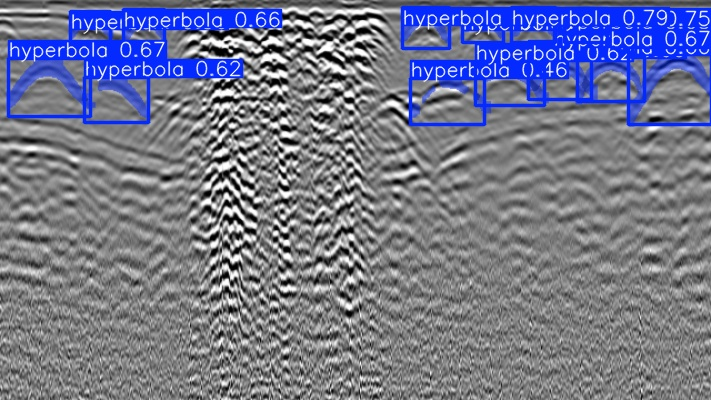

## Chapter 3: Extracting Bounding Boxes and Polygons

Now modifying the Function which was created in **4 Predicting_location_of_hyperbolas_Object_Detection.ipynb** and adjust it so it can extract the polygons and bounding boxes.

In [ ]:
import os
import numpy as np

def extract_boxes_and_polygons(results)-> dict:
    
    all_results = {}

    for result in results:
        img_name = os.path.basename(result.path)
        data = {}
        if result.boxes is not None:
            data["boxes"] = result.boxes.xyxy.cpu().numpy()
            data["conf"] = result.boxes.conf.cpu().numpy()
            
        else:
            data["boxes"] = np.empty((0,4)) 
            data["conf"] = np.empty((0,))      
        
        if hasattr(result, "masks") and result.masks is not None:
            print("found polys")
            polygons = [mask.xy[0].tolist() for mask in result.masks]
            data["polygons"] = polygons
            
        
        else:
            data["polygons"] = []

        all_results[img_name] = data
    return all_results

In [5]:
preds = extract_boxes_and_polygons(results)
print(preds)

found polys
found polys
found polys
found polys
found polys
found polys
found polys
found polys
found polys
{'EG-3D QUER001.SGY_inline_15.png': {'boxes': array([[     396.41,      50.695,       471.7,      114.78],
       [      437.5,      156.54,      505.19,      229.03],
       [     1866.5,      155.15,      1965.5,      250.02],
       [     1735.2,      46.499,      1817.3,       111.1]], dtype=float32), 'conf': array([     0.5658,     0.56179,      0.5484,     0.51444], dtype=float32), 'polygons': [[[393.8343505859375, 54.90312576293945], [393.8343505859375, 92.9046859741211], [404.19842529296875, 92.9046859741211], [411.1077880859375, 85.99530792236328], [414.5625, 85.99530792236328], [418.0171813964844, 82.5406265258789], [421.47186279296875, 82.5406265258789], [424.9265441894531, 79.0859375], [428.3812255859375, 79.0859375], [431.8359375, 75.6312484741211], [435.2906188964844, 75.6312484741211], [445.6546630859375, 85.99530792236328], [449.109375, 85.99530792236328], [456.01

### Chapter 4: Create a file out of the Predictions and Convert the Predictions to 3D

Goal is to create a  CSV File which contains all bounding boxes which are index so as all polygons which are inheritend by those bounding boxes. The Challenge here is to that there has to be created a relationship betweend the images. Starting point is to define how the Structure of the CSV File should look like.

The Structure looks like the following:
|filename|cut_type|cut_number|bbox_number|bbox_data|polygon_data|
|-|-|-|-|-|-|
|file1|inline|1|1|[20,30,40,50]|Ponits of polygon in bbox|

to recreate the structure the extracting function from **Chapter 3** needs to be adjusted.

In [5]:
import os
import numpy as np
import re
import pandas as pd
import json

def match_detections(results, dist_trheshhold, out_path, export:bool = False)-> dict:
    global_boxes = []
    global_id = 0
    records = []

    def center_bbox(box):
        x1,y1,x2,y2 = box
        return ((x1+x2)/2, (y1+y2)/2)
    
    def euclidan_distance(c1, c2):
        return np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)
    
    def parse_filename(filename):
        base_name = os.path.basename(filename)
        
        #getting everything until SGY
        match_main = re.match(r"(.+?\.SGY)", base_name, re.IGNORECASE)
        filename_part = match_main.group(1) if match_main else base_name

        #getting cut_type and cut_number
        match_suffix = re.search(r"_(\w+)[_-](\d+)", base_name)
        cut_type = match_suffix.group(1) if match_suffix else "unknown"
        cut_number = int(match_suffix.group(2)) if match_suffix else -1

        return filename_part, cut_type, cut_number



    for result in results:
        img = os.path.basename(result.path)
        filename, cut_type, cut_number = parse_filename(img)

        if result.boxes is not None:
            boxes = result.boxes.xyxy.cpu().numpy()
           
        else:
            boxes = np.empty((0,4)) 
                  
        
        if hasattr(result, "masks") and result.masks is not None:
            polygons = [mask.tolist() for mask in result.masks.xy]
            
        else:
            polygons = []

        for i, box in enumerate(boxes):
            center = center_bbox(box)
            existing_id = None

            for gid, gcenter in global_boxes:
                if euclidan_distance(center, gcenter)< dist_trheshhold:
                    existing_id = gid
                    break
            
            if existing_id is None:
                existing_id = global_id
                global_boxes.append((global_id,center))
                global_id +=1

            polygon_data = json.dumps(polygons[i] if i < len(polygons) else [])
            bbox_data = json.dumps(box.tolist())
            

            records.append({
                "filename": filename,
                "cut_type": cut_type,
                "cut_number": cut_number,
                "bbox_number": existing_id,
                "bbox_data": bbox_data,
                "polygon_data": polygon_data
            })

    df = pd.DataFrame(records)
    if export:
        df.to_csv(f"{out_path}/results.csv")
       
    return df

Next step is to test the function but first make predictions

In [7]:
results = model.predict(TEST_PIC_DIR,save = True, conf=0.5, boxes=True)

WARNING 'boxes' is deprecated and will be removed in the future. Use 'show_boxes' instead.

image 1/3 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_52.png: 384x640 14 hyperbolas, 100.9ms
image 2/3 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_58.png: 384x640 21 hyperbolas, 89.8ms
image 3/3 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_59.png: 384x640 18 hyperbolas, 85.9ms
Speed: 2.3ms preprocess, 92.2ms inference, 23.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\pythonad\PAINDHS25\PAINDGPR\Notebooks\runs\segment\predict5


In [8]:
detections = match_detections(results= results, dist_trheshhold=5, out_path=OUT_PATH_Detections, export=True )

looks promising with respect to the Dataframme. But for better intepreatation a plot is needed and if its matching with the detections from YOLO.

In [8]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
def plot_matched_detections(df, csv:bool=False, csv_path:str = None):

    if csv:
        df = pd.read_csv(csv_path)
    else:
        df = df

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(projection='3d')

    for i, row in df.iterrows():

        cut_number = row["cut_number"]
        polys = row["polygon_data"]
        bbox_number = row["bbox_number"]

        try:
            polygon = json.loads(polys)
        
        except json.JSONDecodeError:
            continue

        if not polygon or not isinstance(polygon[0], (list, tuple)):
            continue
        
        xs = [p[0] for p in polygon]
        zs = [p[1] for p in polygon]
        ys = [cut_number]

        color = cm.tab20(int(bbox_number)%20)
        ax.plot(xs, ys, zs, color = color, linewidth = 0.8,alpha = 0.5)

    ax.set_xlim(0,711)
    ax.set_zlim(0,400)
    ax.set_xlabel("X Values Polygons")
    ax.set_ylabel("Cut_number")
    ax.set_zlabel("Y Values Polygons")
    ax.invert_zaxis()

    ax.set_title("3D Plot of Detections")

    plt.show()



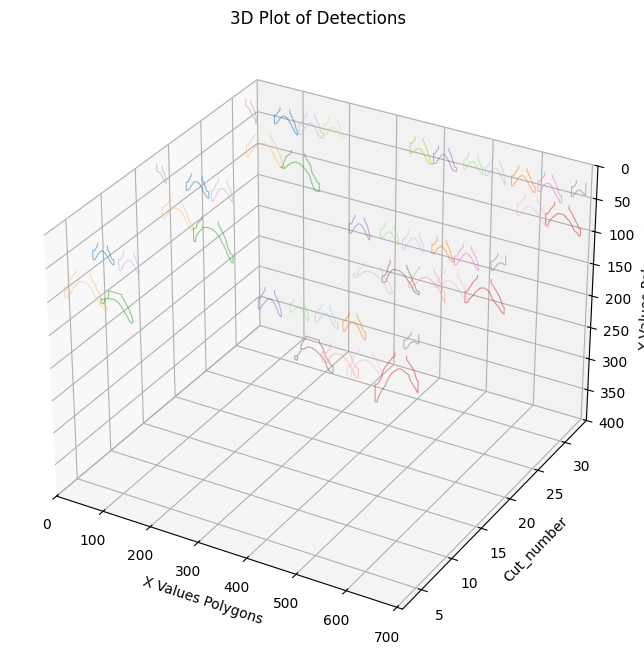

In [9]:
plot_matched_detections(detections)

out of the first plot its not realy clear which hyperbolas are on which inline so the next plot adds those spheres.

In [9]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
def plot_matched_detections(df, csv:bool=False, csv_path:str = None):

    xlim = (0,711)
    zlim = (0,400)

    if csv:
        df = pd.read_csv(csv_path)
    else:
        df = df

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect([1,1,1])

    cuts = sorted(df["cut_number"].unique())
    X, Z = np.meshgrid(np.linspace(xlim[0],xlim[1],10),
                       np.linspace(zlim[0], zlim[1], 10))
    
    for cut in cuts:
        Y = np.ones_like(X) * cut
        ax.plot_surface(X, Y, Z, color="gray", alpha = 0.15, linewidth = 0.3)



    for i, row in df.iterrows():

        cut_number = row["cut_number"]
        polys = row["polygon_data"]
        bbox_number = row["bbox_number"]

        try:
            polygon = json.loads(polys)
        
        except json.JSONDecodeError:
            continue

        if not polygon or not isinstance(polygon[0], (list, tuple)):
            continue
        
        xs = [p[0] for p in polygon]
        zs = [p[1] for p in polygon]
        ys = [cut_number]

        color = cm.tab20(int(bbox_number)%20)
        ax.plot(xs, ys, zs, color = color, linewidth = 0.9,alpha = 0.8,
                label= f"Bounding Box {int(bbox_number)}")

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Bounding Boxes", loc="upper left",
              bbox_to_anchor = (0, 0., 0.5, 1),
              framealpha = 0.0, fontsize = 7)

    ax.set_xlim(xlim[0], xlim[1])
    ax.set_zlim(zlim[0], zlim[1])
    ax.set_xlabel("X Values Polygons = Crosslines")
    ax.set_ylabel("Inline")
    ax.set_zlabel("Y Values Polygons = Time Sample")
    ax.invert_zaxis()

    ax.set_title("3D Plot of Detections")

    plt.show()



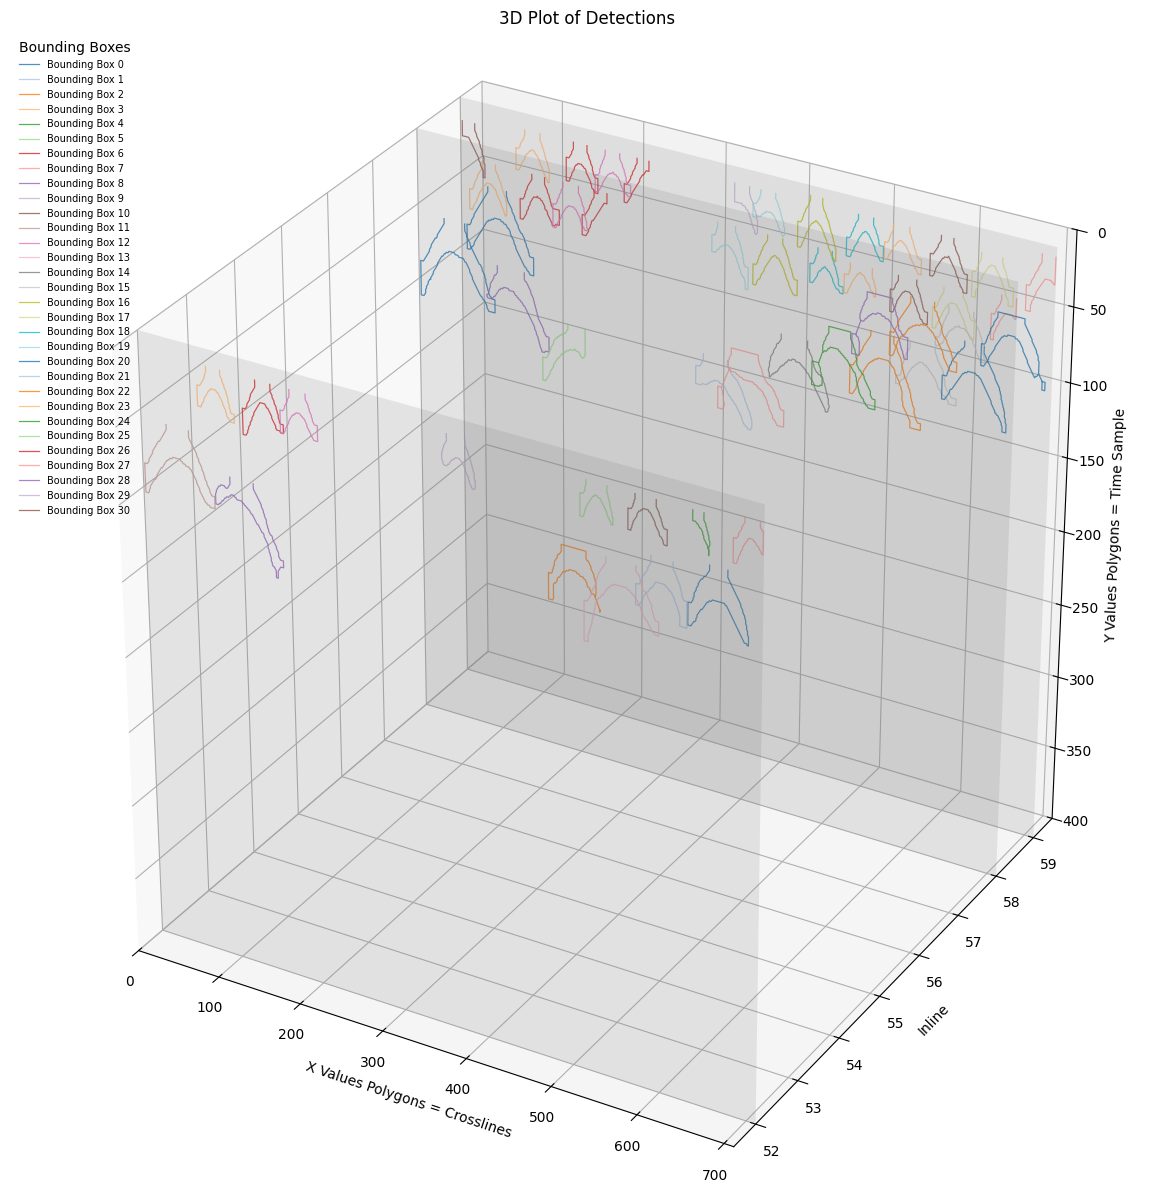

In [10]:
plot_matched_detections(df = detections)

This looks better but still there has to be a way to see if all detections are displayed in the csv and the plot. sot the next step is to create a function which compares the number of polygons in the csv or Dataframe with the number of detections from YOLO.

In [22]:
def validate_detections(results, matched_detections, csv:bool = False, csv_path:str =None):

    if csv:
        matched_df = pd.read_csv(csv_path, sep=",")
    else:
        matched_df = matched_detections

    number_detections_csv_total = matched_df.shape[0]

    polygons_per_image = {}
    for result in results:
        img_name = os.path.basename(result.path)

        # Wenn Masken vorhanden sind
        if hasattr(result, "masks") and result.masks is not None and hasattr(result.masks, "xy"):
            num_polygons = len(result.masks.xy)
        else:
            num_polygons = 0

        polygons_per_image[img_name] = num_polygons

    number_of_detections_results = sum(polygons_per_image.values())

    #Checking if Total Number is the same

    if number_detections_csv_total == number_of_detections_results:
        print("Detections YOLO matching with Matched Detections")
        print(f"Yolo Detections:{number_of_detections_results} Number of Matched Detections {number_detections_csv_total}")
    
    else:
        print(f"Yolo Detections:{number_of_detections_results} Number of Matched Detections {number_detections_csv_total}")

        csv_counts = matched_df.groupby("filename").size().reset_index(name="num_polygons")
        #Checking on which images there are the same

        for img_name, num_polygons in polygons_per_image.items():
            img_name_no_ext = os.path.splitext(img_name)[0]
            count_csv = csv_counts.loc[
                csv_counts['filename'].apply(lambda x: str(x) in img_name_no_ext),
                'num_polygons'
            ]

            if not count_csv.empty:
                print(f"Image: {img_name} YOLO Detections:{num_polygons} Matched Detections: {count_csv[0]}")
            
            else:
                print(f"Image: {img_name} YOLO Detections:{num_polygons} Matched Detections: not found")



In [23]:
validate_detections(results=results, matched_detections=detections)

Detections YOLO matching with Matched Detections
Yolo Detections:53 Number of Matched Detections 53


### Chapter 4: Implementation in Pipeline

We can now implement the **ectract_boxes_and_polygons()** which is a update to the **extract_boxes()** to the **Predictor Class**. Now we can make Predictions on diffrent Model types and extract the relevant information for the type of model. Here the two types which where tested are **Object Detection** and **Instance Segmentation**